# Experiment: Working with Mesh Data

In [1]:
import itertools
import math
import os
!pip install path.py
from path import Path
import random

import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance
!pip install scikit-plot
import scikitplot as skplt

!pip install carbontracker
from carbontracker.tracker import CarbonTracker

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from google.colab import drive
drive.mount('/content/drive')

random.seed = 1234

     |████████████████████████████████| 102kB 7.3MB/s 
Mounted at /content/drive


In [3]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
        
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]

    return verts, faces


class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s *
                   (s - side_a) * 
                   (s - side_b) * 
                   (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points


class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud


class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud


class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)


def default_transforms():
    return transforms.Compose([PointSampler(8192),
                               Normalize(),
                               RandRotation_z(),
                               RandomNoise(),
                               ToTensor()])

In [4]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

In [5]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)

      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      bs = input.size(0)
      # input.shape == (bs,n,3)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))

      # pool = nn.MaxPool1d(xb.size(-1))(xb)
      pool = nn.AvgPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)

      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)

        self.conv1 = nn.Conv1d(3,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)
        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)

        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        # xb = nn.MaxPool1d(xb.size(-1))(xb)
        xb = nn.AvgPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)

        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 2):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)

        self.dropout = nn.Dropout(p=0.3)
        self.logsigmoid = nn.LogSigmoid()

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)

        # return output, matrix3x3, matrix64x64
        return self.logsigmoid(output), matrix3x3, matrix64x64


def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))

    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

# Train

In [6]:
def train(model, train_loader, val_loader=None,  epochs=120, save=True):
    training_loss = []
    test_results = []
    total_time = 0
    tracker = CarbonTracker(epochs)

    for epoch in range(epochs): 
        # starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True) <-throughput

        # starter.record() <-latency
        # pointnet.train() <- latency

        tracker.epoch_start()

        running_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))
            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:
                print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' % 
                      (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                training_loss.append(running_loss / 10)
                running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            test_results.append(val_acc)
            print('Valid accuracy: %d %%' % val_acc)

        tracker.epoch_end()
        # ender.record()
        
        # torch.cuda.synchronize()
        # # curr_time = starter.elapsed_time(ender) #<-- performance
        # # timings[epoch] = curr_time #<-- performance
        # curr_time = starter.elapsed_time(ender)/1000 #<-- throughput
        # total_time += curr_time #<-- throughput

        # save the model
        checkpoint = PATH/ 'save_' + str(epoch) + '.pth'

        if save:
          torch.save(pointnet.state_dict(), checkpoint)
          print('Model saved to ', checkpoint)

    plt.figure(1)
    plt.subplot(211)
    plt.plot(training_loss,
             linewidth=2.0,
             color='blue',
             label='Loss' )
    plt.xlabel('Epochs')
    plt.legend()  

    plt.figure(2)
    plt.subplot(212)
    plt.plot(test_results,
             linewidth=2.0,
             color='green',
             label='Accuraccy')
    plt.xlabel('Epochs')
    plt.legend()

    # mean_syn = np.sum(timings) / epochs
    # std_syn = np.std(timings)
    # print("Mean Synch Time: (in ms)", mean_syn)   

    # throughput = (epochs*32)/total_time
    # print('Final Throughput:', throughput)

# PATH

In [50]:
XYT = Path("/content/drive/My Drive/KM3Net Data/ensemble/xyt/")
XZT = Path("/content/drive/My Drive/KM3Net Data/ensemble/xzt/")
YZT = Path("/content/drive/My Drive/KM3Net Data/ensemble/yzt/")

In [51]:
PATH = YZT

In [52]:
parent_folders = os.listdir(PATH)
folders = [dir for dir in sorted(parent_folders) if os.path.isdir(PATH/dir)]
classes = {folder: i for i, folder in enumerate(folders)};

print("The parent folders: {0}; classes: {1}".format(parent_folders,
                                                     classes))
POINTS =  8192

train_transforms = transforms.Compose([
                    PointSampler(POINTS),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()])

train_ds = PointCloudData(PATH,
                          transform=train_transforms)
valid_ds = PointCloudData(PATH,
                          valid=False,
                          folder='test',
                          transform=train_transforms)

inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

The parent folders: ['1', '0', 'yzt.pth']; classes: {'0': 0, '1': 1}
Train dataset size:  320
Valid dataset size:  80
Number of classes:  2
Sample pointcloud shape:  torch.Size([8192, 3])
Class:  0


In [53]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

pointnet = PointNet()
pointnet.to(device)

optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

cuda:0


In [ ]:
# dummy_input = torch.randn(64, 3,1,dtype=torch.float).to(device)
# starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
# repetitions = 120
# # total_time = 0
# timings=np.zeros((repetitions,1))

# GPU-WARM-UP
# for _ in range(10):
#    _ = pointnet(dummy_input)

# MEASURE PERFORMANCE
train(pointnet, train_loader, valid_loader,  save=False)

CarbonTracker: The following components were found: GPU with device(s) Tesla T4.
CarbonTracker: The following components were found: GPU with device(s) Tesla T4.
[Epoch: 1, Batch:   10 /   10], loss: 0.452
Valid accuracy: 50 %
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:01:38
	Energy:	0.001770 kWh
	CO2eq:	0.520728 g
	This is equivalent to:
	0.004325 km travelled by car
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:01:38
	Energy:	0.001770 kWh
	CO2eq:	0.520728 g
	This is equivalent to:
	0.004325 km travelled by car
CarbonTracker: 
Predicted consumption for 120 epoch(s):
	Time:	3:16:20
	Energy:	0.212393 kWh
	CO2eq:	62.487393 g
	This is equivalent to:
	0.518998 km travelled by car
CarbonTracker: 
Predicted consumption for 120 epoch(s):
	Time:	3:16:20
	Energy:	0.212393 kWh
	CO2eq:	62.487393 g
	This is equivalent to:
	0.518998 km travelled by car
CarbonTracker: Finished monitoring.
CarbonTracker: Finished monitoring.
[Epoch: 2, Batch:   10 /   10], loss: 0.205
V

# Test

In [54]:
pointnet = PointNet()
pointnet.load_state_dict(torch.load(PATH/'yzt.pth'))
pointnet.eval() 

PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,

# XYT

In [33]:
xyt_all_probs = []
xyt_all_preds = []
xyt_all_labels = []

with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        xyt_inputs, xyt_labels = data['pointcloud'].float(), data['category']
        xyt_outputs, __, __ = pointnet(xyt_inputs.transpose(1,2))
        xyt_probs, xyt_preds = torch.max(xyt_outputs.data, 1)
        xyt_all_probs += list(xyt_probs.numpy())
        xyt_all_preds += list(xyt_preds.numpy())
        xyt_all_labels += list(xyt_labels.numpy())

Batch [   1 /    2]
Batch [   2 /    2]


In [34]:
print("Classification report for Pointnet:\n\n {}".format(classification_report(xyt_all_labels,
                                                                            xyt_all_preds,
                                                                            target_names=list(classes.keys()))))


Classification report for Pointnet:

               precision    recall  f1-score   support

           0       0.93      1.00      0.96        40
           1       1.00      0.93      0.96        40

    accuracy                           0.96        80
   macro avg       0.97      0.96      0.96        80
weighted avg       0.97      0.96      0.96        80



FPR [0. 0. 1.] 
 TPR: [0.    0.875 1.   ] 
 THRESHOLDS: [2 1 0] 



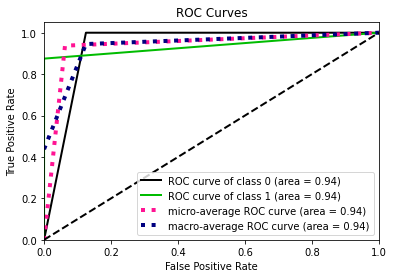

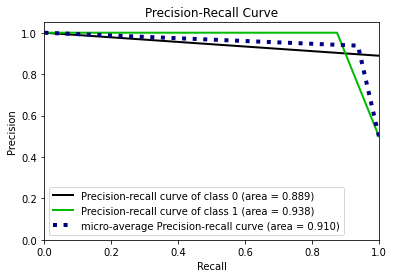

In [30]:
roc_auc = roc_auc_score(xyt_all_labels, xyt_all_preds)
fpr, tpr, thresholds = metrics.roc_curve(xyt_all_labels, xyt_all_preds)
print("FPR {} \n TPR: {} \n THRESHOLDS: {} \n".format(fpr, tpr, thresholds))

xyt_proba = [1 - x for x in xyt_all_preds] 
len(xyt_all_preds)
skplt.metrics.plot_roc(xyt_all_labels, np.column_stack([xyt_proba, xyt_all_preds]))
plt.savefig("./test.jpg", dpi=600, bbox_inches = "tight")

# plt.show()

skplt.metrics.plot_precision_recall(xyt_all_labels,
                                    np.column_stack([xyt_proba, xyt_all_preds]))
plt.savefig("./west.jpg", dpi=600, bbox_inches = "tight")

# plt.show()

In [15]:
cm = confusion_matrix(xyt_all_labels, xyt_all_preds);
cm = np.array(cm)
print(cm)

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization (XYT)')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[40  0]
 [ 3 37]]


In [25]:
cm = np.array([[40, 0], [4, 36]])

Confusion matrix, without normalization (XYT)


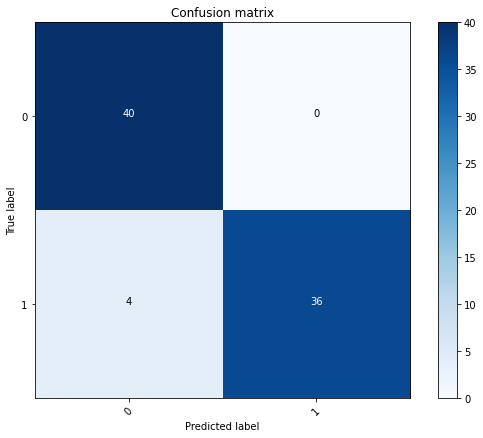

In [26]:
plt.figure(figsize=(8,6))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)
plt.savefig("./test.jpg", dpi=600, bbox_inches = "tight")

# XZT

In [44]:
xzt_all_preds = []
xzt_all_labels = []
xzt_all_probs = []

with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        xzt_inputs, xzt_labels = data['pointcloud'].float(), data['category']
        xzt_outputs, __, __ = pointnet(xzt_inputs.transpose(1,2))
        xzt_probs, xzt_preds = torch.max(xzt_outputs.data, 1)
        xzt_all_probs += list(xzt_probs.numpy())
        xzt_all_preds += list(xzt_preds.numpy())
        xzt_all_labels += list(xzt_labels.numpy())

Batch [   1 /    2]
Batch [   2 /    2]


In [45]:
print("Classification report for Pointnet:\n\n {}".format(classification_report(xzt_all_labels,
                                                                                xzt_all_preds,
                                                                                target_names=list(classes.keys())
                                                                                )))


Classification report for Pointnet:

               precision    recall  f1-score   support

           0       0.85      1.00      0.92        40
           1       1.00      0.82      0.90        40

    accuracy                           0.91        80
   macro avg       0.93      0.91      0.91        80
weighted avg       0.93      0.91      0.91        80



FPR [0. 0. 1.] 
 TPR: [0.    0.825 1.   ] 
 THRESHOLDS: [2 1 0] 



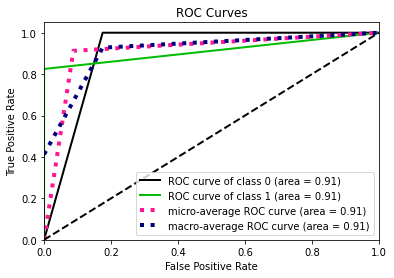

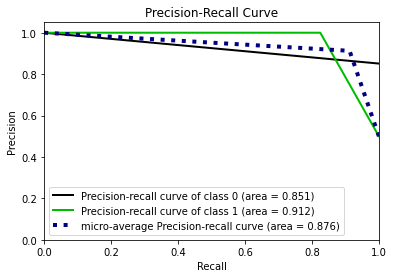

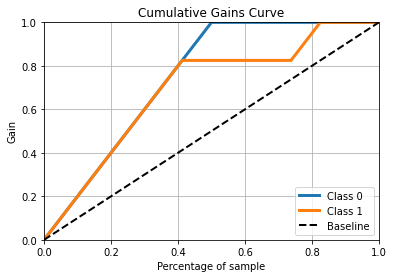

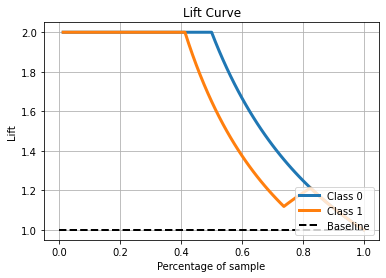

In [46]:
roc_auc = roc_auc_score(xzt_all_labels, xzt_all_preds)
fpr, tpr, thresholds = metrics.roc_curve(xzt_all_labels,
                                         xzt_all_preds)
print("FPR {} \n TPR: {} \n THRESHOLDS: {} \n".format(fpr, tpr, thresholds))

xzt_proba = [1 - x for x in xzt_all_preds] 
len(xzt_all_preds)
skplt.metrics.plot_roc(xzt_all_labels,
                       np.column_stack([xzt_proba, xzt_all_preds]))
plt.savefig("./test.jpg", dpi=600, bbox_inches = "tight")

plt.show()

skplt.metrics.plot_precision_recall(xzt_all_labels,
                                    np.column_stack([xzt_proba, xzt_all_preds]))
plt.savefig("./mest.jpg", dpi=600, bbox_inches = "tight")

In [48]:
cm = confusion_matrix(xzt_all_labels, xzt_all_preds);
cm = np.array(cm)
print(cm)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix (XZT)")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[40  0]
 [ 7 33]]


Confusion matrix, without normalization


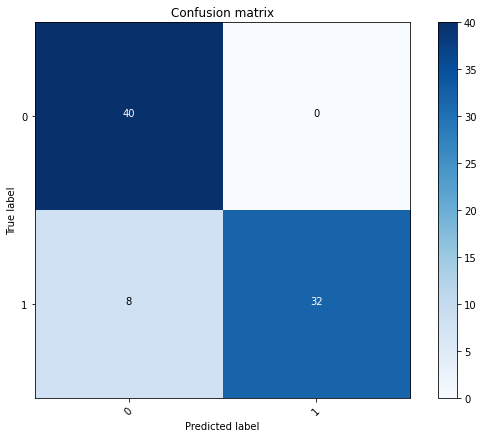

In [49]:
cm = np.array([[40, 0], [8, 32]])
plt.figure(figsize=(8,6))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)
plt.savefig("./test.jpg", dpi=600, bbox_inches = "tight")

# YZT

In [55]:
yzt_all_preds = []
yzt_all_labels = []
yzt_all_probs = []

with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        yzt_inputs, yzt_labels = data['pointcloud'].float(), data['category']
        yzt_outputs, __, __ = pointnet(yzt_inputs.transpose(1,2))
        yzt_probs, yzt_preds = torch.max(yzt_outputs.data, 1)
        
        yzt_all_probs += list(yzt_probs.numpy())        
        yzt_all_preds += list(yzt_preds.numpy())
        yzt_all_labels += list(yzt_labels.numpy())

Batch [   1 /    2]
Batch [   2 /    2]


In [56]:
print("Classification report for Pointnet:\n\n {}".format(classification_report(yzt_all_labels,
                                                                            yzt_all_preds,
                                                                            target_names=list(classes.keys()))))


Classification report for Pointnet:

               precision    recall  f1-score   support

           0       0.97      0.97      0.97        40
           1       0.97      0.97      0.97        40

    accuracy                           0.97        80
   macro avg       0.97      0.97      0.97        80
weighted avg       0.97      0.97      0.97        80



FPR [0.    0.025 1.   ] 
 TPR: [0.    0.975 1.   ] 
 THRESHOLDS: [2 1 0] 



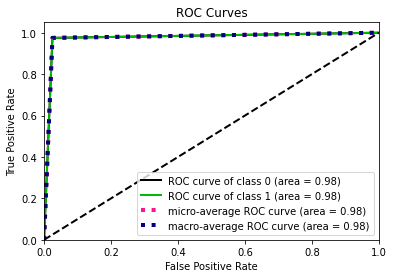

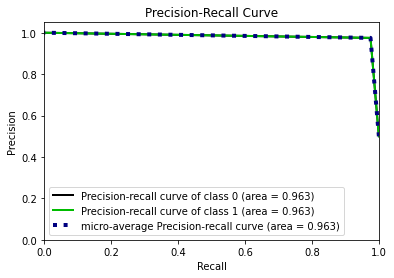

In [57]:
roc_auc = roc_auc_score(yzt_all_labels, yzt_all_preds)
fpr, tpr, thresholds = metrics.roc_curve(yzt_all_labels, yzt_all_preds)
print("FPR {} \n TPR: {} \n THRESHOLDS: {} \n".format(fpr, tpr, thresholds))

yzt_proba = [1 - x for x in yzt_all_preds] 
len(yzt_all_preds)
skplt.metrics.plot_roc(yzt_all_labels,
                       np.column_stack([yzt_proba, yzt_all_preds]))
plt.savefig("./test.jpg", dpi=600, bbox_inches = "tight")

plt.show()

skplt.metrics.plot_precision_recall(yzt_all_labels,
                                    np.column_stack([yzt_proba, yzt_all_preds]))
plt.savefig("./mest.jpg", dpi=600, bbox_inches = "tight")

In [58]:
cm = confusion_matrix(yzt_all_labels, yzt_all_preds);
cm = np.array(cm)
print(cm)

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization (YZT)')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[39  1]
 [ 1 39]]


Confusion matrix, without normalization (YZT)


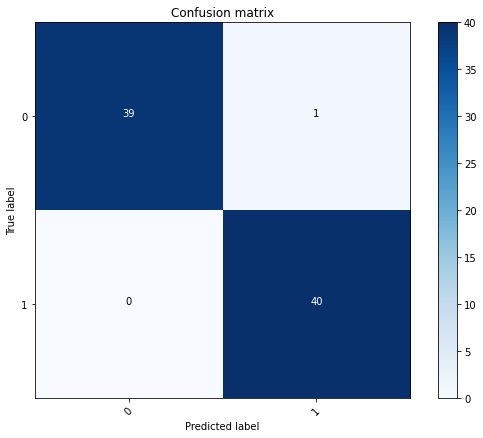

In [60]:
cm=np.array([[39, 1], [0, 40]])
plt.figure(figsize=(8,6))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)
plt.savefig("./test.jpg", dpi=600, bbox_inches = "tight")


# Hard Voting

In [61]:
# For hard voting:
from collections import Counter

hard_votes = []
hard_proba = []

zipped_preds = zip(xyt_all_preds,
                   xzt_all_preds,
                   yzt_all_preds)
zipped_probs = zip(xyt_all_probs,
                   xzt_all_probs, 
                   yzt_all_probs)

for pred in zipped_preds:
  most_common,_ = Counter(pred).most_common(1)[0]
  hard_votes.append(most_common)

for proba in zipped_probs:
  most_common, _ = Counter(proba).most_common(1)[0]
  hard_proba.append(most_common)

FPR [0. 0. 1.] 
 TPR: [0. 1. 1.] 
 THRESHOLDS: [2 1 0] 



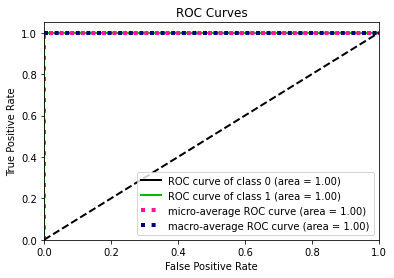

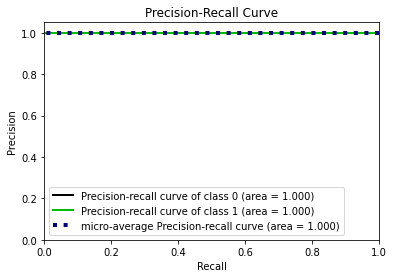

In [63]:
roc_auc = roc_auc_score(yzt_all_labels, hard_votes)
fpr, tpr, thresholds = metrics.roc_curve(yzt_all_labels, hard_votes)
print("FPR {} \n TPR: {} \n THRESHOLDS: {} \n".format(fpr, tpr, thresholds))

hard_proba = [1 - x for x in hard_votes] 
len(hard_votes)

skplt.metrics.plot_roc(yzt_all_labels,
                       np.column_stack([hard_proba, hard_votes]))
plt.savefig("./test.jpg", dpi=600, bbox_inches = "tight")

plt.show()

skplt.metrics.plot_precision_recall(yzt_all_labels,
                                    np.column_stack([hard_proba, hard_votes]))
plt.savefig("./west.jpg", dpi=600, bbox_inches = "tight")

Hard Voting: Classification report for Pointnet:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

[[40  0]
 [ 0 40]]
Hard Voting: Confusion matrix, without normalization


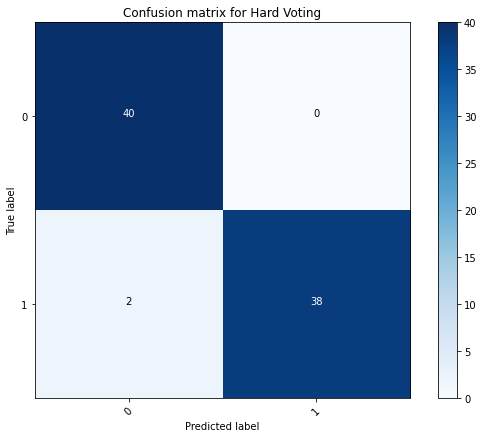

In [65]:
print("Hard Voting: Classification report for Pointnet:\n\n {}".format(classification_report(yzt_all_labels,
                                                                            hard_votes,
                                                                            target_names=list(classes.keys()))))


cm = confusion_matrix(yzt_all_labels, hard_votes);
cm = np.array(cm)
print(cm)

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix for Hard Voting', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Hard Voting: Normalized confusion matrix")
    else:
        print('Hard Voting: Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = np.array([[40,0],[2,38]])
plt.figure(figsize=(8,6))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)
plt.savefig("./test.jpg", dpi=600, bbox_inches = "tight")


# Soft Voting

In [66]:
THRESHOLD = .90

soft_votes = []
zipped_probabilities = zip(xyt_all_preds,
                           xzt_all_preds,
                           yzt_all_preds)

for item in zipped_probabilities:
  average = sum(item)/3
  soft_votes.append(average)
soft_votes = [1 if vote > THRESHOLD else 0 for vote in soft_votes]

FPR [0. 0. 1.] 
 TPR: [0.    0.725 1.   ] 
 THRESHOLDS: [2 1 0] 



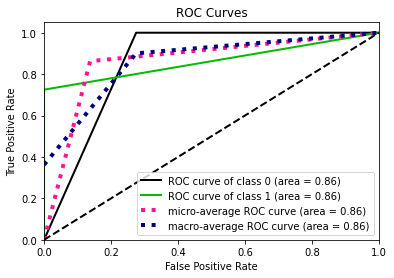

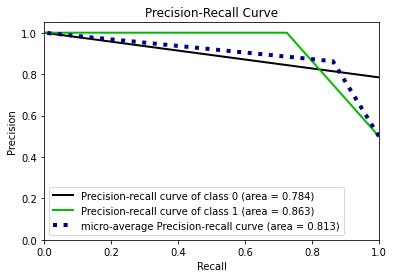

In [67]:
roc_auc = roc_auc_score(xzt_all_labels, soft_votes)
fpr, tpr, thresholds = metrics.roc_curve(yzt_all_labels, soft_votes)
print("FPR {} \n TPR: {} \n THRESHOLDS: {} \n".format(fpr, tpr, thresholds))

soft_proba = [1 - x for x in soft_votes] 

skplt.metrics.plot_roc(yzt_all_labels,
                       np.column_stack([soft_proba, soft_votes]))
plt.savefig("./test.jpg", dpi=600, bbox_inches = "tight")

plt.show()

skplt.metrics.plot_precision_recall(yzt_all_labels,
                                    np.column_stack([soft_proba, soft_votes]))
plt.savefig("./west.jpg", dpi=600, bbox_inches = "tight")

Soft Voting Voting: Classification report for Pointnet:

               precision    recall  f1-score   support

           0       0.78      1.00      0.88        40
           1       1.00      0.72      0.84        40

    accuracy                           0.86        80
   macro avg       0.89      0.86      0.86        80
weighted avg       0.89      0.86      0.86        80

[[40  0]
 [11 29]]
Soft Voting: Confusion matrix, without normalization


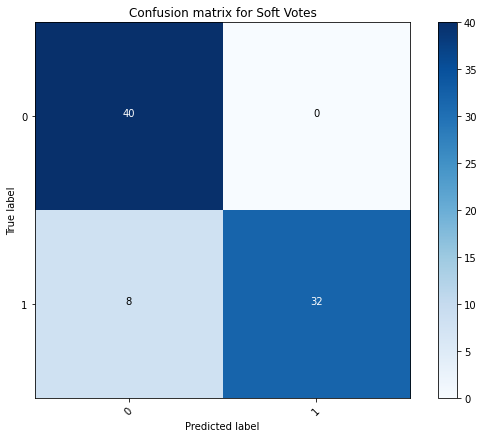

In [69]:
print("Soft Voting Voting: Classification report for Pointnet:\n\n {}".format(classification_report(yzt_all_labels,
                                                                            soft_votes,
                                                                            target_names=list(classes.keys()))))

cm = confusion_matrix(yzt_all_labels, soft_votes);
cm = np.array(cm)
print(cm)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix for Soft Votes', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Soft Voting: Normalized confusion matrix")
    else:
        print('Soft Voting: Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = np.array([[40,0],[8,32]])
plt.figure(figsize=(8,6))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)
plt.savefig("./test.jpg", dpi=600, bbox_inches = "tight")